In [98]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [99]:
train_df = pd.read_csv('./data/BBC News Train.csv')
test_df = pd.read_csv('./data/BBC News Test.csv')
df = pd.concat([train_df, test_df])

### Some helper methods I'll use throughout this notebook

In [100]:
def plot_confusion_matrix(yt, yp, reordered_categories):
    cm = confusion_matrix(yt.apply(lambda x: reordered_categories.index(x)), yp) 
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=reordered_categories, yticklabels=reordered_categories)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def reorder_categories(labels, categories):
    reordered_categories = []
    label_map = dict(zip(labels, categories))
    # map each category to its corresponding label
    for i in range(5):
        reordered_categories.append(label_map[i])
    return reordered_categories

In [101]:
# remove stop words from Text
stop_words = set(stopwords.words("english"))
df["Text"] = df["Text"].apply(
    lambda x: " ".join([word for word in x.split() if word.lower() not in stop_words])
)

In [102]:
categories = list(train_df["Category"].unique())

## Borrowed from week 2 lab
def accuracy_score(y_true, y_pred):
    """
    Calculate accuracy score.
    y_true: true labels
    y_pred: predicted labels
    Returns accuracy as a float.
    """
    return np.mean(y_true == y_pred)


# permutate topics to see which ones go with which categories
def label_permute_compare(ytdf, yp, n=5):
    """
    ytdf: labels dataframe object
    yp: nmf label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    perms = list(itertools.permutations(list(range(n))))
    acc = []
    for i in range(len(perms)):
        mapdict = dict(zip(categories, list(perms[i])))
        yt = ytdf.apply(lambda x: mapdict[x])
        acc.append(accuracy_score(yt, yp))
    idx = np.argmax(acc)
    return perms[idx], acc[idx]

### First Use Labels to Test Accuracy

In the end we can combine the train and test datasets because this isn't a supervised learning exercise, but in order to truly measure the accuracy of the labels we have to use the train dataset because it has labels with it.

In [103]:
# Convert to TF-IDF
n_features = 1000
n_top_words = 20
n_topics = 5

vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = vectorizer.fit_transform(train_df["Text"])
print(vectorizer.transform(train_df["Text"]).shape)
print(train_df["Category"].value_counts())

(1490, 1000)
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


In [104]:
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

labels, train_acc = label_permute_compare(
    train_df["Category"], nmf.transform(vectorizer.transform(train_df["Text"])).argmax(axis=1), n_topics
)
print(f"Labels: {labels}, Accuracy: {train_acc:.2f}")
reordered_categories = reorder_categories(labels, categories)
print(f"Reordered categories: {reordered_categories}")

Labels: (0, 4, 1, 2, 3), Accuracy: 0.89
Reordered categories: ['business', 'politics', 'sport', 'entertainment', 'tech']


In [105]:
# Get the test responses just for fun
tfidf_test = vectorizer.transform(test_df['Text'])

# compare to test_y
predicted_topics = nmf.transform(vectorizer.transform(test_df['Text'])).argmax(axis=1)

()
submission_df = test_df.copy()
submission_df['Category'] = [reordered_categories[i] for i in predicted_topics]
submission_df[['ArticleId', 'Category']].to_csv('./output/submission.csv', index=False)

### Combined train and test because unsupervised algorithm doesn't need labels

In [106]:
full_tfidf = vectorizer.fit_transform(df["Text"])
yp = nmf.transform(vectorizer.transform(df["Text"])).argmax(axis=1)
print(yp)


[4 0 2 ... 4 2 4]


### Optimum Hyperparameters

Loop through 3 different hyperparameters and identify which combination provides the best accuracy.

In [107]:
# In order to test the accuracy with different hyperparameters I need to know the labels so there is some data splitting here
X_train, X_test, y_train, y_test = train_test_split(
    train_df["Text"], train_df["Category"], test_size=0.2, random_state=42
)


# Try different types of max_df and min_df and compare the accuracies
def evaluate_tfidf_params(max_df, min_df, n_features, train_x, test_x, train_y, test_y):
    vectorizer = TfidfVectorizer(
        max_df=max_df, min_df=min_df, max_features=n_features, stop_words="english"
    )
    tfidf = vectorizer.fit_transform(train_x)
    nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

    labels, train_acc = label_permute_compare(
        train_y, nmf.transform(vectorizer.transform(train_x)).argmax(axis=1), n_topics
    )
    label_map = dict(zip(categories, labels))

    tfidf_test = vectorizer.transform(test_x)
    predicted_topics = nmf.transform(tfidf_test)
    yp = predicted_topics.argmax(axis=1)

    test_acc = accuracy_score(test_y.apply(lambda x: label_map[x]), yp)

    return train_acc, test_acc, yp, labels


# Example usage of evaluate_tfidf_params
max_dfs = [0.99, 0.95, 0.9, 0.85, 0.8]
min_dfs = [2, 3, 4, 10, 20]
features_array = [250, 500, 1000, 1500, 2000, 2500]
acc = 0

# Make a table of the accuracies for all permutations of max_df, min_df, and n_features
results = []
best_accuracy = 0
best_params = None
for max_df in max_dfs:
    for min_df in min_dfs:
        for n_features in features_array:
            train_acc, test_acc, _, _ = evaluate_tfidf_params(
                max_df=max_df,
                min_df=min_df,
                n_features=n_features,
                train_x=X_train,
                test_x=X_test,
                train_y=y_train,
                test_y=y_test,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_params = (max_df, min_df, n_features)
            results.append(
                {
                    "max_df": max_df,
                    "min_df": min_df,
                    "n_features": n_features,
                    "train_accuracy": train_acc,
                    "test_accuracy": test_acc,
                }
            )
results_df = pd.DataFrame(results)
# Save the results to a CSV file
results_df.to_csv("tfidf_results.csv", index=False)
# Print the results DataFrame
print(best_params)

(0.8, 3, 2500)


In [108]:
# I didn't quite figure out how to use Word2Vec with NMF, so I will leave this commented out for now.
# One thing I noticed was that the Word2Vec model returned negative values, which NMF does not accept.
# I tried to set negative values to zeroes, but it didn't work well with NMF.
# The shape of the Word2Vec vectors was also different from the TF-IDF vectors, which made it difficult to use NMF directly.

# # Try out word2vec instead of TF-IDF
# from gensim.models import Word2Vec
# # Create a Word2Vec model
# word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)
# print(X_train.shape)
# # Use NMF to find topics just like before
# # Split the data into training and test sets
# # Fit NMF on the Word2Vec features
# w2v_vectors = word2vec_model.wv.vectors
# print(w2v_vectors.shape)
# # Set negative values to zeroes
# w2v_vectors[w2v_vectors < 0] = 0
# print(w2v_vectors.shape)
# nmf_w2v = NMF(n_components=n_topics, random_state=1).fit(w2v_vectors)
# print(nmf_w2v.components_.shape)
# # Get labels and accuracy for train_y using Word2Vec features
# labels_w2v, train_acc_w2v = label_permute_compare(y_train, nmf_w2v.transform(w2v_vectors).argmax(axis=1), n_topics)
# print(f'Train accuracy with Word2Vec: {train_acc_w2v:.2f}')
# # Predict topics for the test set using Word2Vec features

In [109]:
# lemmatize the text from the TFIDF section and run it through again
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatized_text = train_df["Text"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

X_train, X_test, y_train, y_test = train_test_split(
    lemmatized_text, train_df["Category"], test_size=0.2, random_state=42
)

best_accuracy = 0
best_params = None
for max_df in max_dfs:
    for min_df in min_dfs:
        for n_features in features_array:
            train_acc, test_acc, _, _ = evaluate_tfidf_params(
                max_df=max_df,
                min_df=min_df,
                n_features=n_features,
                train_x=X_train,
                test_x=X_test,
                train_y=y_train,
                test_y=y_test,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_params = (max_df, min_df, n_features)
print(best_params)

(0.99, 10, 2000)


### Oddly worse with bigrams

In [110]:
# bigram the text and then run tfidf
vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', max_df=0.8, min_df=4, max_features=1500)
train_x = vectorizer.fit_transform(X_train)
nmf = NMF(n_components=n_topics, random_state=1).fit(train_x)

labels, train_acc = label_permute_compare(
    y_train, nmf.transform(vectorizer.transform(X_train)).argmax(axis=1), n_topics
)
label_map = dict(zip(categories, labels))

test_x = vectorizer.transform(X_test)
predicted_topics = nmf.transform(test_x)
yp = predicted_topics.argmax(axis=1)

test_acc = accuracy_score(y_test.apply(lambda x: label_map[x]), yp)

print(f"Bigram Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")

Bigram Train Accuracy: 0.64, Test Accuracy: 0.64


### Confusion Matrix for Optimal Hyperparameters

Accuracy: 0.93


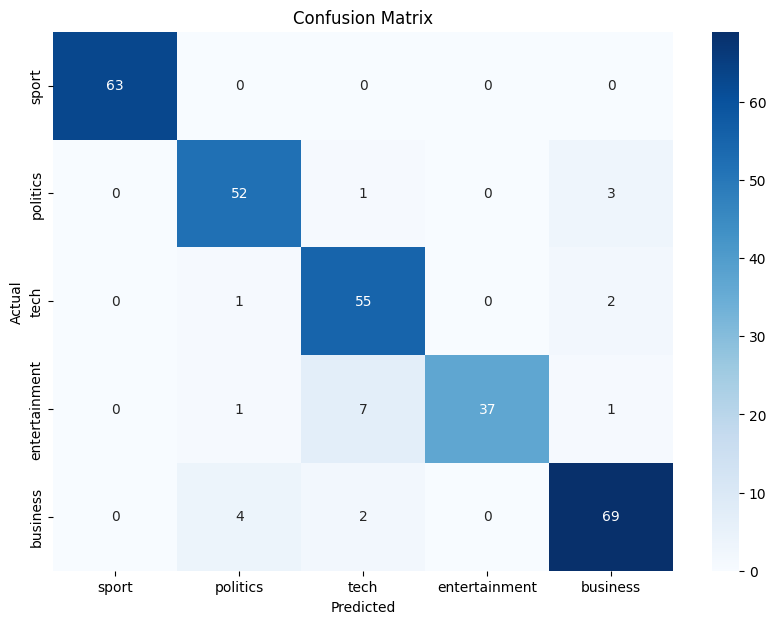

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df["Text"], train_df["Category"], test_size=0.2, random_state=42
)
train_acc, test_acc, yp, labels = evaluate_tfidf_params(.8, 4, 1500, X_train, X_test, y_train, y_test)

print(f"Accuracy: {test_acc:.2f}")
reordered_categories = reorder_categories(labels, categories)
plot_confusion_matrix(y_test, yp, reordered_categories)
